In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from catboost import CatBoostRegressor
import datetime
from sklearn import preprocessing
from matplotlib import pyplot as plt
import math

In [2]:
df_z = pd.read_parquet('../../data/pre_processed/covid_cases_z_trans.parquet')

# Parameter testing, K-means clustering

This notebook was used to test which clustering parameters for K-means clustering achive the highest accuracy when forecasting. All results from executing this notebook are stored in cluster_evaluation_results.

In [3]:
#Function used to perform prediction. Input: forecasting model, traning dataframe, test dataframe, 
#list of features, and number of predictions, default 8. Returns dataframe with same format as
#additional test_df, with an additional column with predictions.

def predict(model, training_df, test_df, feature_list, num_predictions=8):
    start_period = 0
    end_period = num_predictions
    prediction_list = []
    
    #Generating an encoder for country feature by converting country string to int value
    if 'Country' in feature_list:
        ns_encoder = preprocessing.LabelEncoder()
        training_df['Country'] =  ns_encoder.fit_transform(training_df['Country'])
    
    #Dataframe with all features
    x_training_df = training_df[feature_list].copy()
    #Dataframe with all cases
    y_training_df = training_df['Cases'].copy().to_frame()
    model.fit(x_training_df, np.ravel(y_training_df))
    
    # Predicting on test set, while end period is not equal to end of length of test_df
    while end_period <= len(test_df):
        # Collect features from start to end and predict (10-10-2020->17-10-2020)
        features_df = test_df[feature_list][start_period:end_period].copy()
        #Generating an encoder for country feature by converting country string to int value
        if 'Country' in feature_list:
            features_df['Country'] = ns_encoder.transform(features_df['Country'])
        true_df = test_df[['Cases']][start_period:end_period].copy()
        predictions = model.predict(features_df)
       
        # Add the predicted data
        predicted_df = pd.DataFrame(predictions, columns=['predicted'])
        predicted_df.index = true_df.index.copy()        
        prediction_list.extend(predictions)
        # Move to next period
        start_period += 1
        end_period += 1
    
    df_result = test_df.assign(Predicted=prediction_list)
    return df_result

In [4]:
#Function that computes a MAPE. Input: dataframe including true and prediction,
#true_column that specifies which column of df holds the true values and 
#pred_column that specifies which column of df hold the predicted values
def MAPE(df,true_column,pred_column):
    true_list = df[true_column].to_numpy()
    pred_list = df[pred_column].to_numpy()
    return np.mean(np.abs((true_list - pred_list) / true_list)) * 100

In [5]:
#Function computes an additional column which sums predicted value together to form an accumulated
#prediction. Prediction for day 0 is summed to the known total cases the day before.
#Input: dataframe contanint all data on test country and dataframe including predictions produced
#by def forecast. 
def accumulated_dataframe_column(df_test_country,CB_df):
    test_start_value = df_test_country.loc[df_test_country.index == datetime.datetime(2020,9,9), 'cases_tot'].values[0]
    accumulated_list = [math.floor(test_start_value+CB_df['Predicted'][0])]
    for i in range(1,len(CB_df)):
        accumulated_list.append(math.floor(accumulated_list[i-1]+CB_df['Predicted'][i]))
    df_result = CB_df.copy()
    df_result['Accumulated_Prediction'] = accumulated_list
    return df_result

## Creating cluster

Parameters can be changed her. See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html for documentation.

In [6]:
kmeans_z = KMeans(n_clusters=4, random_state=42, init='k-means++', n_init=100, algorithm='auto').fit(df_z.T)

Array matching each country to its assigned cluster:

In [7]:
labels_kmeans_z = kmeans_z.labels_[:]
labels_kmeans_z

array([2, 2, 2, 3, 1, 1, 1, 3, 2, 2, 3, 1, 2, 2, 0, 1, 0, 3, 2, 2, 3, 2,
       3, 3, 1, 0, 0, 3, 2, 2, 1, 2, 3, 2, 2, 2, 2, 1, 3, 2, 3, 0, 2, 0,
       2, 0, 2, 3, 1, 3, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0,
       2, 0, 1, 1, 3, 3, 1, 0, 3, 2, 1, 3, 1, 1, 2, 2, 2], dtype=int32)

Distribution of countries between clusters:

In [8]:
print("K-means:")
print("Countries in cluster 0:", np.count_nonzero(labels_kmeans_z == 0))
print("Countries in cluster 1:", np.count_nonzero(labels_kmeans_z == 1))
print("Countries in cluster 2:", np.count_nonzero(labels_kmeans_z == 2))
print("Countries in cluster 3:", np.count_nonzero(labels_kmeans_z == 3))

K-means:
Countries in cluster 0: 12
Countries in cluster 1: 24
Countries in cluster 2: 30
Countries in cluster 3: 17


Creating a new dataframe for each cluster. The new formed dataframes have same format as df_z, however only the respective countries present in each cluster are included in each new dataframe. 

In [9]:
df_kmeans_z_0 = df_z.T.loc[labels_kmeans_z== 0].transpose()
df_kmeans_z_1 = df_z.T.loc[labels_kmeans_z == 1].transpose()
df_kmeans_z_2 = df_z.T.loc[labels_kmeans_z == 2].transpose()
df_kmeans_z_3 = df_z.T.loc[labels_kmeans_z == 3].transpose()

Plotting the created clusters:

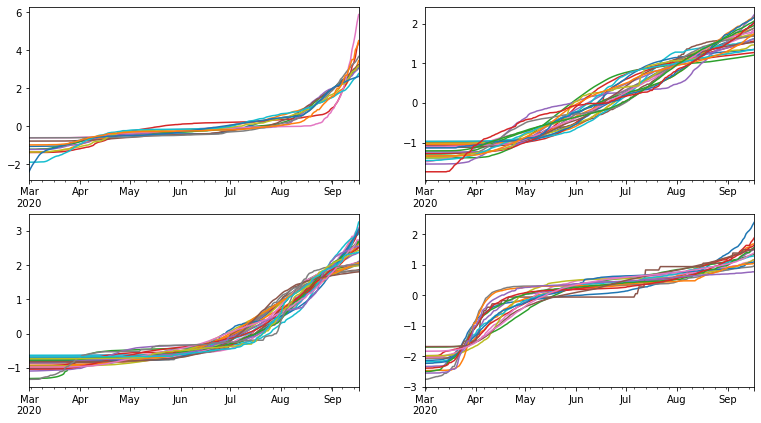

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(13, 7)
df_kmeans_z_0.plot(legend='', ax=axes[0,0])
df_kmeans_z_1.plot(legend='', ax=axes[0,1])
df_kmeans_z_2.plot(legend='', ax=axes[1,0])
df_kmeans_z_3.plot(legend='', ax=axes[1,1])

## Selecting test countries

In [11]:
df_forecasting = pd.read_parquet('../../data/forecasting_format/dataframe_forecasting_with_features.parquet')

In [12]:
Algeria_df = df_forecasting [df_forecasting['Country'].isin(['Algeria'])]

In [13]:
test_1_df =  Algeria_df[(Algeria_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Algeria_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [14]:
Belgium_df = df_forecasting[df_forecasting['Country'].isin(['Belgium'])]

In [15]:
test_2_df =  Belgium_df[(Belgium_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Belgium_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [16]:
Bangladesh_df = df_forecasting[df_forecasting['Country'].isin(['Bangladesh'])]

In [17]:
test_3_df =  Bangladesh_df[(Bangladesh_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Bangladesh_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [18]:
Croatia_df = df_forecasting[df_forecasting['Country'].isin(['Croatia'])]

In [19]:
test_4_df =  Croatia_df[(Croatia_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Croatia_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [20]:
selected_clusters = []
test_countries_not_used = []

In [21]:
def forecasting(k_means_countries_list,k_means_df,country_df,test_df):
    k_means_df = df_forecasting[df_forecasting['Country'].isin(k_means_countries_list)]
    k_means_training_df = k_means_df[(k_means_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (k_means_df.index.date <= datetime.date(2020, 9, 9))].copy()
    feature_list = ['Country','Month','Day','prev_case']
    params= {'iterations': 5000, 'silent': True}
    model = CatBoostRegressor(**params)
    k_means_CB_df = predict(model=model, training_df=k_means_training_df.copy(), 
                                                             test_df=test_df.copy(),
                                                             feature_list=feature_list)
    k_means_CB_df = accumulated_dataframe_column(country_df,k_means_CB_df)
    return k_means_CB_df

## Forecasting, cluster with Algeria

Select correct cluster

In [22]:
if 'Algeria' in df_kmeans_z_0.columns and 'df_kmeans_z_0' not in selected_clusters:
    k_means_1_df = df_kmeans_z_0.copy()
    selected_clusters.append('df_kmeans_z_0')
elif 'Algeria' in df_kmeans_z_1.columns and 'df_kmeans_z_1' not in selected_clusters:
    k_means_1_df = df_kmeans_z_1.copy()
    selected_clusters.append('df_kmeans_z_1')
elif 'Algeria' in df_kmeans_z_2.columns and 'df_kmeans_z_2' not in selected_clusters:
    k_means_1_df = df_kmeans_z_2.copy()
    selected_clusters.append('df_kmeans_z_2')
elif 'Algeria' in df_kmeans_z_3.columns and 'df_kmeans_z_3' not in selected_clusters:
    k_means_1_df = df_kmeans_z_3.copy()
    selected_clusters.append('df_kmeans_z_3')
else:
    test_countries_not_used.append('Algeria')

In [23]:
print(selected_clusters)
print(test_countries_not_used)

['df_kmeans_z_2']
[]


In [24]:
if 'Algeria' not in test_countries_not_used:
    k_means_1_countries_list = list(k_means_1_df.columns)
    k_means_1_CB_df = forecasting(k_means_1_countries_list,k_means_1_df,Algeria_df,test_1_df)

In [25]:
print(k_means_1_countries_list)

['Algeria', 'Argentina', 'Australia', 'Bolivia', 'Bulgaria', 'Colombia', 'Costa Rica', 'Dominican Republic', 'El Salvador', 'Ethiopia', 'India', 'Indonesia', 'Iraq', 'Israel', 'Japan', 'Kazakhstan', 'Kenya', 'Malawi', 'Mexico', 'Mozambique', 'Nepal', 'Panama', 'Philippines', 'Romania', 'Rwanda', 'South Africa', 'Ukraine', 'Vietnam', 'Zambia', 'Zimbabwe']


In [26]:
print(len(k_means_1_countries_list))

30


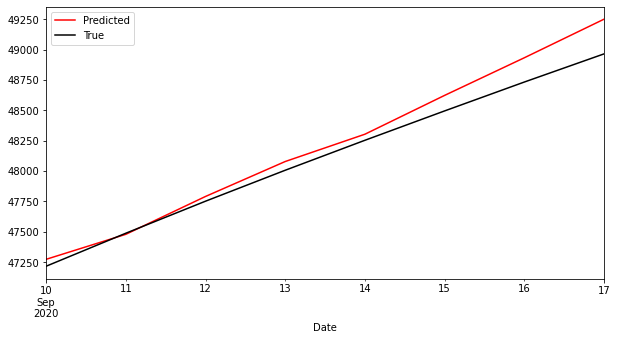

In [27]:
k_means_1_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE k_means 1:

In [28]:
round(MAPE(k_means_1_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2167

## K-means z trans, cluster with Belgium

Select correct cluster

In [29]:
if 'Belgium' in df_kmeans_z_0.columns and 'df_kmeans_z_0' not in selected_clusters:
    k_means_2_df = df_kmeans_z_0.copy()
    selected_clusters.append('df_kmeans_z_0')
elif 'Belgium' in df_kmeans_z_1.columns and 'df_kmeans_z_1' not in selected_clusters:
    k_means_2_df = df_kmeans_z_1.copy()
    selected_clusters.append('df_kmeans_z_1')
elif 'Belgium' in df_kmeans_z_2.columns and 'df_kmeans_z_2' not in selected_clusters:
    k_means_2_df = df_kmeans_z_2.copy()
    selected_clusters.append('df_kmeans_z_2')
elif 'Belgium' in df_kmeans_z_3.columns and 'df_kmeans_z_3' not in selected_clusters:
    k_means_2_df = df_kmeans_z_3.copy()
    selected_clusters.append('df_kmeans_z_3')
else:
    test_countries_not_used.append('Belgium')

In [30]:
print(selected_clusters)
print(test_countries_not_used)

['df_kmeans_z_2', 'df_kmeans_z_3']
[]


In [31]:
if 'Belgium' not in test_countries_not_used:
    k_means_2_countries_list = list(k_means_2_df.columns)
    k_means_2_CB_df = forecasting(k_means_2_countries_list,k_means_2_df,Belgium_df,test_2_df)

In [32]:
print(k_means_2_countries_list)

['Austria', 'Belgium', 'Canada', 'Denmark', 'Estonia', 'Fiji', 'Finland', 'Iceland', 'Ireland', 'Latvia', 'Malaysia', 'New Zealand', 'Norway', 'Switzerland', 'Thailand', 'Turkey', 'United Kingdom']


In [33]:
print(len(k_means_2_countries_list))

17


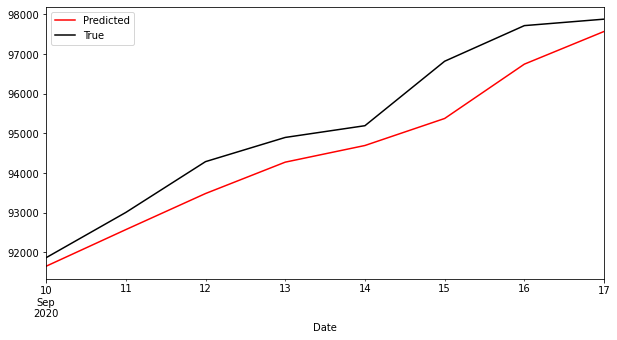

In [34]:
k_means_2_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE k_means 2:

In [35]:
round(MAPE(k_means_2_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.6917

## K-means z trans, cluster with Bangladesh

Select correct cluster

In [36]:
if 'Bangladesh' in df_kmeans_z_0.columns: #and 'df_kmeans_z_0' not in selected_clusters:
    k_means_3_df = df_kmeans_z_0.copy()
    selected_clusters.append('df_kmeans_z_0')
elif 'Bangladesh' in df_kmeans_z_1.columns: # and 'df_kmeans_z_1' not in selected_clusters:
    k_means_3_df = df_kmeans_z_1.copy()
    selected_clusters.append('df_kmeans_z_1')
elif 'Bangladesh' in df_kmeans_z_2.columns: # and 'df_kmeans_z_2' not in selected_clusters:
    k_means_3_df = df_kmeans_z_2.copy()
    selected_clusters.append('df_kmeans_z_2')
elif 'Bangladesh' in df_kmeans_z_3.columns: # and 'df_kmeans_z_3' not in selected_clusters:
    k_means_3_df = df_kmeans_z_3.copy()
    selected_clusters.append('df_kmeans_z_3')
else:
    test_countries_not_used.append('Bangladesh')

In [37]:
print(selected_clusters)
print(test_countries_not_used)

['df_kmeans_z_2', 'df_kmeans_z_3', 'df_kmeans_z_1']
[]


In [38]:
if 'Bangladesh' not in test_countries_not_used:
    k_means_3_countries_list = list(k_means_3_df.columns)
    k_means_3_CB_df = forecasting(k_means_3_countries_list,k_means_3_df,Bangladesh_df,test_3_df)

In [39]:
print(k_means_3_countries_list)

['Bahrain', 'Bangladesh', 'Belarus', 'Chile', 'Cuba', 'Ghana', 'Iran', 'Kuwait', 'Nigeria', 'Oman', 'Pakistan', 'Peru', 'Poland', 'Qatar', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia', 'Sri Lanka', 'Sweden', 'Togo', 'United Arab Emirates', 'United States', 'Uruguay']


In [40]:
print(len(k_means_3_countries_list))

24


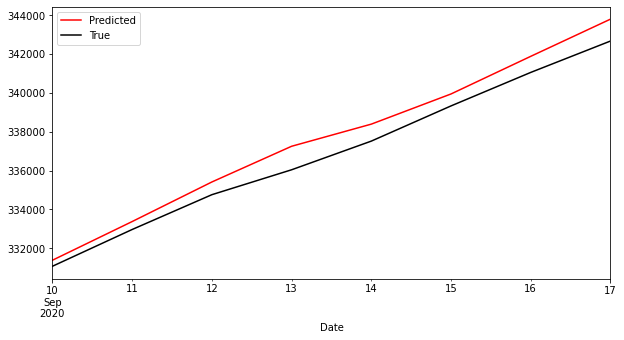

In [41]:
k_means_3_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE k_means 3:

In [42]:
round(MAPE(k_means_3_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.223

## K-means z trans, cluster with Croatia

Select correct cluster

In [43]:
if 'Croatia' in df_kmeans_z_0.columns: # and 'df_kmeans_z_0' not in selected_clusters:
    k_means_4_df = df_kmeans_z_0.copy()
    selected_clusters.append('df_kmeans_z_0')
elif 'Croatia' in df_kmeans_z_1.columns: # and 'df_kmeans_z_1' not in selected_clusters:
    k_means_4_df = df_kmeans_z_1.copy()
    selected_clusters.append('df_kmeans_z_1')
elif 'Croatia' in df_kmeans_z_2.columns: # and 'df_kmeans_z_2' not in selected_clusters:
    k_means_4_df = df_kmeans_z_2.copy()
    selected_clusters.append('df_kmeans_z_2')
elif 'Croatia' in df_kmeans_z_3.columns: # and 'df_kmeans_z_3' not in selected_clusters:
    k_means_4_df = df_kmeans_z_3.copy()
    selected_clusters.append('df_kmeans_z_3')
else:
    test_countries_not_used.append('Croatia')

In [44]:
print(selected_clusters)
print(test_countries_not_used)

['df_kmeans_z_2', 'df_kmeans_z_3', 'df_kmeans_z_1', 'df_kmeans_z_0']
[]


In [45]:
if 'Croatia' not in test_countries_not_used:
    k_means_4_countries_list = list(k_means_4_df.columns)
    k_means_4_CB_df = forecasting(k_means_4_countries_list,k_means_4_df,Croatia_df,test_4_df)

In [46]:
print(k_means_4_countries_list)

['Croatia', 'Czech Republic', 'Greece', 'Hungary', 'Malta', 'Morocco', 'Myanmar', 'Paraguay', 'Slovakia', 'Slovenia', 'South Korea', 'Tunisia']


In [47]:
print(len(k_means_4_countries_list))

12


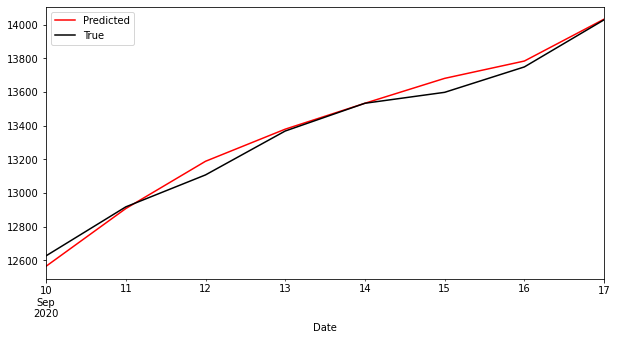

In [48]:
k_means_4_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

MAPE k_means 4:

In [49]:
round(MAPE(k_means_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2703

Total MAPE

In [50]:
round(MAPE(k_means_1_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(MAPE(k_means_2_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(MAPE(k_means_3_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(MAPE(k_means_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

1.4017